# Figure 3. SUPP Seasonal precipitation and population dynamics

In [9]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # to build a LOWESS model
import json

### 1. Set up model
Parameters:

In [ ]:
# MOSQUITO
alphaO=0.5  # rate that eggs hatch into larvae
alphaL=0.18  # rate that larvae pupate
alphaP=1  # rate that pupae eclose
phi=500*(1/14)    # number eggs laid per mosquito per day
muO=0.01    # daily death rate of eggs
muL=0.1*alphaL    # daily death rate of larvae
muP=0.1*alphaP     # pupae death rate
muM=1/14     # adult mosquito death rate
muF=1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA=1   # determines the density at which mortality remains proportionate
BB=0.5   # determines the 'abruptness' of density-dependence

Initial conditions:
(equilibrium values previously defined in Supp)

In [11]:
O0=15947.608023052446
L0=40271.71074193975
P0=32.67541200187585
M0=228.72754035145144
F0=228.72754035145144

Seasonality function:

In [12]:
with open("Rio.json", 'r') as f:
    score = json.load(f)  
    
def K(t):
    return score[round(t)]

Model:

In [13]:
def deriv_pre(y, t, phi, alphaO, muO, K, AA, BB, alphaL, alphaP, muP, muM, muF):
    
    O, L, P, M, F = y
    
    #MOSQUITOES
        
    allmales = 1+M
    
    #Eggs
    dOdt = phi * F * M/allmales - alphaO*O - muO*O
    # eggs laid * total females * total males/ all males

    #Larvae
    dLdt =  alphaO*O - alphaL*L - muL*L
    
    #Pupae
    dPdt =  alphaL*(L/((1+(AA*K(t)*L))**BB)) - alphaP*P - muP*P
    
    #Adult
    dMdt =  0.5*alphaP*P - muM*M
    
    dFdt =  0.5*alphaP*P - muF*F    
    
    return dOdt, dLdt, dPdt, dMdt, dFdt

Model prerequisites:

In [14]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, L0, P0, M0, F0 # initial condition vector

Run model:

In [15]:
ret = odeint(deriv_pre, y0, t, args=(phi, alphaO, muO, K, AA, BB, alphaL, alphaP, muP, muM, muF),hmax=1)

O, L, P, M, F = ret.T

### 2. Results
Format data:

In [ ]:
pop = M+F
days = range(1501)
Bobo = np.genfromtxt(fname="Rio_long.txt") # import precipitation data
Bobo2 = sm.nonparametric.lowess(Bobo[:,1], Bobo[:,0], frac=0.8/3) # smooth the curve
prec = Bobo2[:,1]
month = Bobo2[:,0]

t1 = days # weekly time points
t2 = month*30 # monthly time points
data0 = pop # adult mosquito population
data1 = prec # precipitation values

Plot results:

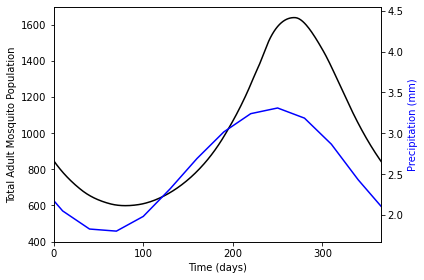

In [16]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Total Adult Mosquito Population')
ax1.plot(t1, data0, color='black')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Precipitation (mm)', color='blue')
ax2.plot(t2, data1, color='blue')
ax1.set_xlim(500,865)
positions = (500, 600, 700, 800)
labels = ("0", "100", "200", "300")
plt.xticks(positions, labels)
fig.tight_layout()

#plt.savefig('seasonality_adult_pop_vs_precipitation_16.8.22.jpeg', bbox_inches='tight', dpi = 300)